# Training a Custom Model Using CSV Files 

This tutorial demonstrates how to train a custom machine learning classifier for automated spike sorting curation using **pre-computed CSV files**. This approach is ideal when you:

- Already have quality metrics computed and exported as CSV files
- Want to train models on data from multiple recording sessions
- Need to work with metrics from different spike sorting software


## Overview:
1. **Load CSV data**: Import quality metrics and curation labels  
2. **Data preparation**: Process and validate the input data
3. **Train classifier**: Test multiple algorithms and preprocessing strategies
4. **Evaluate performance**: Analyze model accuracy and feature importance
5. **Apply to new data**: Use the trained model for automated curation

**Note:** This tutorial uses example CSV files. Replace them with your actual quality metrics and manual curation labels for real applications.

## Required Files (located in `data/` folder):
- `data/quality_metrics.csv`: Computed quality metrics for each unit
- `data/cluster_group.tsv`: Manual curation labels (good/mua/noise)
- `data/new_data.csv`: New dataset for applying the trained model

## Import Packages and Setup

In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spikeinterface as si
import spikeinterface.widgets as sw

# Print versions for reproducibility
print(f"SpikeInterface version: {si.__version__}")


from pathlib import Path
# Import UnitRefine - adjust path if needed
try:
    from UnitRefine.scripts.train_manual_curation import train_model
    print("✓ UnitRefine imported successfully")
except ImportError:
    # If UnitRefine is not installed, add the local path
    import sys
    # Get current working directory and navigate to UnitRefine root
    current_path = Path.cwd()
    # Navigate to the directory containing the UnitRefine folder
    unitrefine_root = current_path.parent.parent.parent  # Go to c:\Users\jain\Documents\GitHub\UnitRefine
    sys.path.append(str(unitrefine_root))
    from UnitRefine.scripts.train_manual_curation import train_model
    print("✓ UnitRefine imported from local path")

## Alternative: Import from SpikeInterface package (if available)
# from spikeinterface.curation import train_model

# Configure for performance (adjust based on your system)
si.set_global_job_kwargs(n_jobs=4)
print("Tutorial setup complete!")

SpikeInterface version: 0.102.3
✓ UnitRefine imported from local path
Tutorial setup complete!


## Step 1: Load the Training Data

First, let's load our quality metrics the dataset structure. The quality metrics CSV file contains quantitative measurements for each unit that help distinguish between good units and noise/artifacts.

In [3]:
print("📁 Loading quality metrics data...")

# Check if the file exists
if not os.path.exists('data/quality_metrics.csv'):
    print("⚠️  'data/quality_metrics.csv' not found in current directory")
    print("    Make sure to download the required files first!")
    current_directory = os.getcwd()
    print(f"    Current directory: {current_directory}")
else:
    # Load the data from 'data/quality_metrics.csv' into a DataFrame
    metrics = pd.read_csv('data/quality_metrics.csv')
    print(f"✓ Loaded quality metrics: {metrics.shape[0]} units, {metrics.shape[1]} columns")

# Define comprehensive list of quality and template metrics
metrics_cols = [
    # Firing pattern metrics
    'num_spikes', 'firing_rate', 'presence_ratio', 
    
    # Signal quality metrics  
    'snr', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
    
    # Contamination metrics
    'isi_violations_ratio', 'isi_violations_count', 'rp_contamination', 'rp_violations', 'sliding_rp_violation',
    
    # Synchrony metrics
    'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 
    
    # Stability metrics
    'firing_range', 'drift_ptp', 'drift_std', 'drift_mad',
    
    # Cluster separation metrics
    'isolation_distance', 'l_ratio', 'd_prime', 'silhouette', 'nn_hit_rate', 'nn_miss_rate'
]

print(f"\n📊 Metrics to be used for training: {len(metrics_cols)} features")

📁 Loading quality metrics data...
✓ Loaded quality metrics: 796 units, 27 columns

📊 Metrics to be used for training: 26 features


## Step 2: Load and Process Curation Labels

Now let's load the manual curation labels. These represent expert decisions about unit quality and serve as the "ground truth" for training our classifier.

In [7]:
print("🏷️  Loading curation labels...")

# Check if labels file exists
if not os.path.exists('data/cluster_group.tsv'):
    print("⚠️  'data/cluster_group.tsv' not found in current directory")
    print("    Make sure to download the required files first!")
else:
    # Load human-curated labels from 'data/cluster_group.tsv' file
    labels_df = pd.read_csv('data/cluster_group.tsv', sep='\t')
    print(f"✓ Loaded curation labels: {len(labels_df)} units")
    
    # Display the raw labels
    print(f"\n📋 Label Distribution:")
    label_counts = labels_df['group'].value_counts()
    print(label_counts)
    
    print(f"\n🔍 Sample of raw labels:")
    display(labels_df.head())
    
    # Map label names to binary classification:
    # 'good' clusters → 1 (keep)
    # 'mua' (multi-unit activity) and 'noise' → 0 (discard)
    
    label_mapping = {'good': 1, 'mua': 0, 'noise': 0}
    
    # Apply the label mapping
    labels_df['binary_label'] = labels_df['group'].map(label_mapping)
    
    # Display the mapping
    print(f"\n🏷️ Label Mapping:")
    for original, binary in label_mapping.items():
        count = len(labels_df[labels_df['group'] == original])
        print(f"   {original} → {binary} ({count} units)")
    
    print(f"\n✅ Binary Label Distribution:")
    binary_counts = labels_df['binary_label'].value_counts()
    mapped_counts = binary_counts.rename(index={1: 'Keep (1)', 0: 'Discard (0)'})
    print(mapped_counts)
    
    # Create labels array for training
    labels_to_train = labels_df['binary_label'].values
    print(f"\n✅ Created training labels array: {len(labels_to_train)} labels")

🏷️  Loading curation labels...
✓ Loaded curation labels: 796 units

📋 Label Distribution:
group
mua      403
noise    331
good      62
Name: count, dtype: int64

🔍 Sample of raw labels:


,cluster_id,group
0,0,noise
1,1,noise
2,2,noise
3,3,noise
4,4,noise



🏷️ Label Mapping:
   good → 1 (62 units)
   mua → 0 (403 units)
   noise → 0 (331 units)

✅ Binary Label Distribution:
binary_label
Discard (0)    734
Keep (1)        62
Name: count, dtype: int64

✅ Created training labels array: 796 labels


In [8]:
# Check current working directory and file availability
current_directory = os.getcwd()
print(f"📁 Current working directory: {current_directory}")

# Check for required files in data directory
required_files = ['data/quality_metrics.csv', 'data/cluster_group.tsv', 'data/new_data.csv']
print(f"\n📋 File availability check:")
for file in required_files:
    exists = os.path.exists(file)
    status = "✓" if exists else "✗"
    print(f"   {status} {file}")

print(f"\n💡 Note: All data files should be in the 'data' subdirectory")

📁 Current working directory: c:\Users\jain\Documents\GitHub\UnitRefine\UnitRefine\tutorial\train_model

📋 File availability check:
   ✓ data/quality_metrics.csv
   ✓ data/cluster_group.tsv
   ✓ data/new_data.csv

💡 Note: All data files should be in the 'data' subdirectory


## Step 3: Train the Classifier

Now we'll train machine learning classifiers to learn the relationship between quality metrics and curation decisions. The training pipeline will:

### Training Pipeline:

**🔄 Model Selection**: Tests multiple algorithms (Random Forest, Gradient Boosting, Logistic Regression, etc.)

**🔧 Data Preprocessing**: 
- **Imputation**: Handles missing values using strategies like median, mean, or mode
- **Feature scaling**: Normalizes metrics using StandardScaler, RobustScaler, etc.

For improved model performance and generalization, it's recommended to:
- Use atleast 2 datasets from different recording sessions
- Include diverse experimental conditions (different animals, brain regions, etc.)

In [9]:
print("🚀 Starting model training...")
print("Testing multiple classifier configurations for optimal performance...\n")

# Create output folder for the trained model
output_folder = "data"

# For this tutorial, we duplicate the same dataset to demonstrate the multi-dataset workflow
# In practice, you should use different CSV files from multiple recording sessions
trainer = train_model(
    mode="csv",                                    # Use CSV files as input
    labels=[labels_to_train, labels_to_train],    # List of label arrays (one per CSV)
    metrics_paths=['data/quality_metrics.csv', 'data/quality_metrics.csv'],  # List of CSV file paths
    folder=output_folder,                          # Output directory for model files
    
    # Feature selection
    metric_names=metrics_cols,                     # Specify which metrics to use for training
    
    # Data preprocessing strategies
    imputation_strategies=["median"],  # Handle missing values
    scaling_techniques=["standard_scaler"],  # Feature normalization
    
    # Machine learning algorithms to test
    classifiers=["RandomForestClassifier"],

    # File management
    overwrite=True                      # Overwrite existing model folder
    
)
# Access the best performing model pipeline
best_model = trainer.best_pipeline

🚀 Starting model training...
Testing multiple classifier configurations for optimal performance...



In [10]:
# Display the complete pipeline
best_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=4, min_samples_split=3,
                                        n_estimators=150,
                                        random_state=np.int64(159024417)))])

## Step 4: Analyze Model Performance

Let's examine how well our trained models performed and understand which configurations worked best.

In [11]:
# Load and analyze model performance results
print("📊 Loading model performance results...")

accuracy_file = Path(output_folder) / "model_accuracies.csv"
if accuracy_file.exists():
    accuracies = pd.read_csv(accuracy_file, index_col=0)
    
    print("🎯 Model Performance Summary:")
    print("=" * 50)
    
    # Display key performance metrics
    best_accuracy = accuracies['balanced_accuracy'].max()
    best_precision = accuracies['precision'].max()
    best_recall = accuracies['recall'].max()
    
    print(f"Best Balanced Accuracy: {best_accuracy:.3f}")
    print(f"Best Precision: {best_precision:.3f}")
    print(f"Best Recall: {best_recall:.3f}")
    
    print(f"\n📋 All Tested Configurations:")
    display(accuracies.round(3))
    
    # Show the best performing configuration
    best_idx = accuracies['balanced_accuracy'].idxmax()
    best_config = accuracies.loc[best_idx]
    print(f"\n🏆 Best Configuration Details:")
    print(f"   Classifier: {best_config.get('classifier name', 'N/A')}")
    print(f"   Imputation: {best_config.get('imputation_strategy', 'N/A')}")
    print(f"   Scaling: {best_config.get('scaling_strategy', 'N/A')}")
    
else:
    print("⚠️  Model accuracies file not found. Make sure training completed successfully.")

📊 Loading model performance results...
🎯 Model Performance Summary:
Best Balanced Accuracy: 0.953
Best Precision: 0.922
Best Recall: 0.953

📋 All Tested Configurations:


,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),0.953,0.922,0.953,0,"OrderedDict([('class_weight', 'balanced_subsam..."



🏆 Best Configuration Details:
   Classifier: RandomForestClassifier
   Imputation: median
   Scaling: StandardScaler()


## Step 5: Feature Importance Analysis

Understanding which metrics are most important for classification helps validate the model and provides biological insights.

📈 Analyzing feature importance...
🔍 Top 10 Most Important Features:
 1. l_ratio                   0.1553
 2. isi_violations_ratio      0.1160
 3. sync_spike_2              0.0965
 4. d_prime                   0.0943
 5. rp_contamination          0.0846
 6. nn_hit_rate               0.0789
 7. num_spikes                0.0527
 8. firing_range              0.0507
 9. firing_rate               0.0460
10. amplitude_median          0.0388


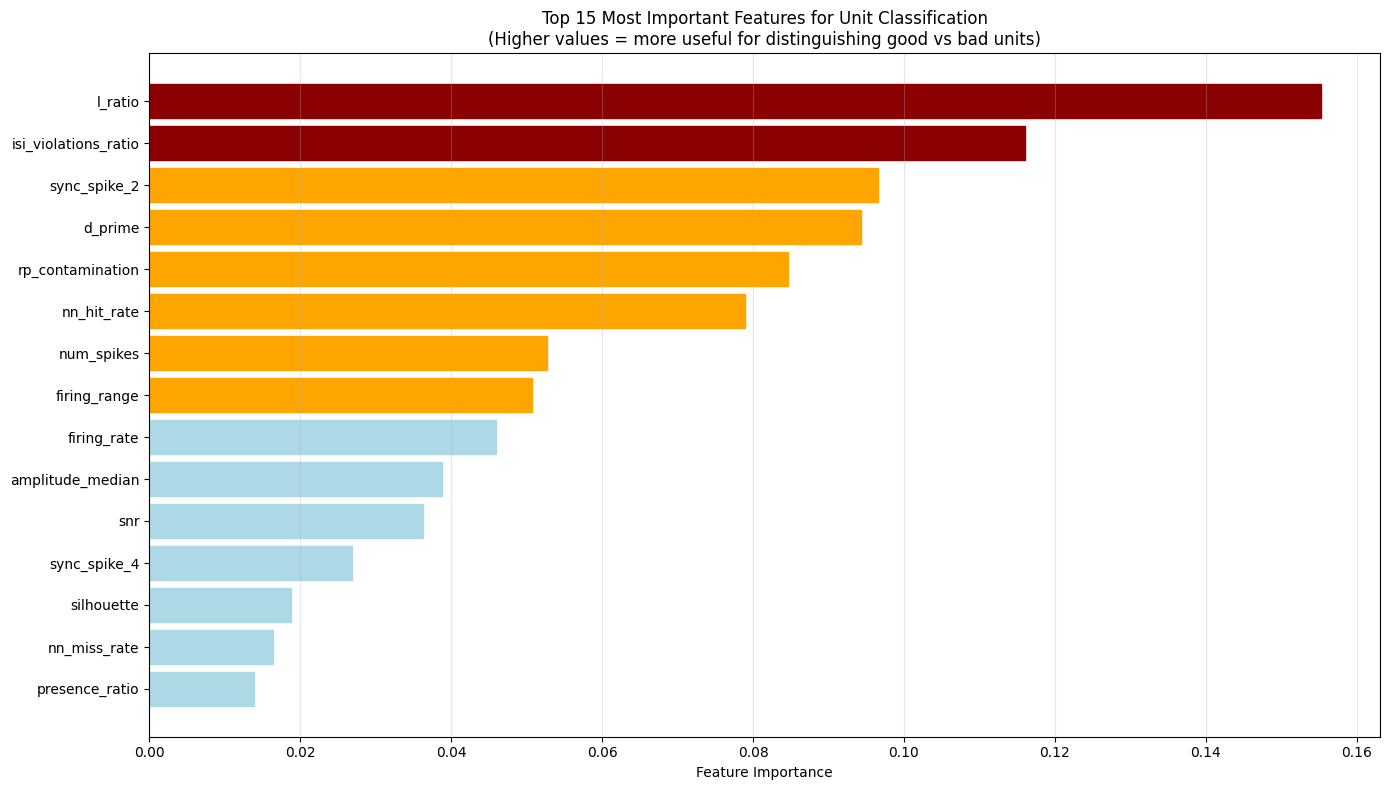


📊 Feature Importance Summary:
   Total features used: 26
   Features with >5% importance: 8
   Top feature contributes: 15.5% of decision making

🏷️  Feature Categories:
   Quality metrics: 11 features
   Contamination metrics: 8 features
   Separation metrics: 6 features


In [12]:
print("📈 Analyzing feature importance...")

# Get feature importances from the best model
try:
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = best_model.feature_names_in_
    
    # Create a DataFrame for easier analysis
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top 10 most important features
    print(f"🔍 Top 10 Most Important Features:")
    print("=" * 50)
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")
    
    # Create enhanced visualization
    plt.figure(figsize=(14, 8))
    top_features = importance_df.head(15)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features for Unit Classification\n(Higher values = more useful for distinguishing good vs bad units)')
    plt.gca().invert_yaxis()
    
    # Color code by importance level
    for i, bar in enumerate(bars):
        importance = top_features.iloc[i]['importance']
        if importance > 0.1:
            bar.set_color('darkred')
        elif importance > 0.05:
            bar.set_color('orange')
        else:
            bar.set_color('lightblue')
    
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3)
    plt.show()
    
    # Summary statistics
    print(f"\n📊 Feature Importance Summary:")
    print(f"   Total features used: {len(importance_df)}")
    print(f"   Features with >5% importance: {len(importance_df[importance_df['importance'] > 0.05])}")
    print(f"   Top feature contributes: {importance_df.iloc[0]['importance']:.1%} of decision making")
    
    # Categorize features by type
    quality_features = [f for f in feature_names if any(qm in f.lower() for qm in ['isi', 'rate', 'presence', 'snr', 'amplitude'])]
    contamination_features = [f for f in feature_names if any(cf in f.lower() for cf in ['violation', 'contamination', 'drift'])]
    separation_features = [f for f in feature_names if any(sf in f.lower() for sf in ['isolation', 'ratio', 'silhouette', 'prime'])]
    
    print(f"\n🏷️  Feature Categories:")
    print(f"   Quality metrics: {len(quality_features)} features")
    print(f"   Contamination metrics: {len(contamination_features)} features")
    print(f"   Separation metrics: {len(separation_features)} features")
    
except Exception as e:
    print(f"⚠️  Could not analyze feature importance: {e}")
    print("   This might happen with some classifier types that don't support feature_importances_")

## Step 6: Apply Model to New Data

Now let's test our trained model on new, unseen data to demonstrate how it would be used in practice for automated curation.

### Load New Dataset

We'll load a new CSV file containing quality metrics for units that the model hasn't seen during training.

In [13]:
print("📁 Loading new data for prediction...")

# Check if new data file exists
if not os.path.exists('data/new_data.csv'):
    print("⚠️  'data/new_data.csv' not found in current directory")
    print("    Make sure the file is in the data directory")
else:
    # Load the new dataset
    new_data = pd.read_csv('data/new_data.csv')
    print(f"✓ Loaded new dataset: {new_data.shape[0]} units, {new_data.shape[1]} columns")
    
    # Check if required metrics columns are present
    missing_cols = [col for col in metrics_cols if col not in new_data.columns]
    if missing_cols:
        print(f"⚠️  Missing columns in new data: {missing_cols}")
        print(f"    Available columns: {list(new_data.columns)}")
    else:
        print(f"✓ All required metric columns present in new dataset")

📁 Loading new data for prediction...
✓ Loaded new dataset: 50 units, 39 columns
✓ All required metric columns present in new dataset


In [14]:
# Display overview of new dataset
if 'new_data' in locals():
    print("🔍 New Dataset Overview:")
    print(f"   Shape: {new_data.shape}")
    print(f"   Missing values: {new_data.isnull().sum().sum()}")
    
    print(f"\n📋 First 5 rows of new data:")
    display(new_data.head())
    
    # Show basic statistics for key metrics
    if all(col in new_data.columns for col in ['firing_rate', 'snr', 'isi_violations_ratio']):
        print(f"\n📈 Key Metrics Summary:")
        display(new_data[['firing_rate', 'snr', 'isi_violations_ratio', 'presence_ratio']].describe().round(3))
else:
    print("❌ New data not loaded - check file availability")

🔍 New Dataset Overview:
   Shape: (50, 39)
   Missing values: 324

📋 First 5 rows of new data:


,cluster_id,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks,velocity_above,velocity_below,exp_decay,spread,cluster_id.1
0,459,7554.0,0.991884,0.825397,12.204892,0.000000,0.0,0.000000,0.0,0.09,...,0.000177,409416.50,-73214.555,1.0,1.0,NaN,1005.7152,0.033996,100.0,459
1,347,48762.0,6.402733,1.000000,5.323073,0.358733,336.0,0.456548,220.0,0.28,...,0.000170,418076.47,-56493.640,1.0,1.0,NaN,495.7309,0.030732,120.0,347
2,178,140.0,0.018383,0.325397,5.208024,0.000000,0.0,0.000000,0.0,NaN,...,0.000180,129573.65,-12767.139,1.0,1.0,NaN,NaN,0.020515,120.0,178
3,87,686.0,0.090076,0.960317,5.549027,0.000000,0.0,0.000000,0.0,NaN,...,0.000170,586757.25,-64506.984,1.0,1.0,412.77590,NaN,0.045614,120.0,87
4,338,15684.0,2.059400,1.000000,8.601093,4.437615,430.0,1.000000,322.0,NaN,...,0.000163,287102.75,-33741.290,2.0,1.0,318.68643,NaN,0.031914,60.0,338



📈 Key Metrics Summary:


,firing_rate,snr,isi_violations_ratio,presence_ratio
count,50.000,50.000,50.000,50.000
mean,1.569,8.024,7.730,0.763
std,3.571,4.451,19.931,0.279
min,0.002,1.368,0.000,0.071
25%,0.024,4.981,0.000,0.536
50%,0.398,7.107,0.117,0.929
75%,1.202,10.036,4.092,1.000
max,22.235,22.357,122.425,1.000


### Make Predictions

Now we'll use our trained model to predict unit quality for the new dataset.

In [15]:
# Extract features from new dataset (same columns as training data)
new_data_features = new_data[metrics_cols].values
print(f"Prepared {new_data_features.shape[0]} units for prediction with {new_data_features.shape[1]} features")

Prepared 50 units for prediction with 26 features


In [16]:
# Apply the trained model to predict unit quality
predictions = best_model.predict(new_data_features)
prediction_probabilities = best_model.predict_proba(new_data_features)

In [17]:
# Display prediction summary
print(f"Model predictions for {len(predictions)} units:")
print("\nUnit Quality Distribution:")
unique, counts = np.unique(predictions, return_counts=True)
for quality, count in zip(unique, counts):
    percentage = (count / len(predictions)) * 100
    print(f"  {quality}: {count} units ({percentage:.1f}%)")

Model predictions for 50 units:

Unit Quality Distribution:
  0: 38 units (76.0%)
  1: 12 units (24.0%)


In [18]:
# Show detailed results for first few units
print(f"\nDetailed predictions for first 10 units:")
print("Unit\tPredicted Quality\tConfidence")
print("-" * 40)
for i in range(min(10, len(predictions))):
    confidence = np.max(prediction_probabilities[i]) * 100
    print(f"{i+1}\t{predictions[i]}\t\t{confidence:.1f}%")


Detailed predictions for first 10 units:
Unit	Predicted Quality	Confidence
----------------------------------------
1	1		76.0%
2	0		82.5%
3	0		98.9%
4	1		57.6%
5	0		95.6%
6	0		94.6%
7	0		100.0%
8	0		100.0%
9	0		100.0%
10	1		72.9%


### Save Predictions

Let's save our predictions for future reference and analysis.

In [19]:
# Create a results dataframe with predictions
results_df = new_data.copy()
results_df['predicted_quality'] = predictions

# Add prediction confidence
max_probabilities = np.max(prediction_probabilities, axis=1)
results_df['prediction_confidence'] = max_probabilities

# Save predictions to file
output_path = 'data/model_predictions.csv'
results_df.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")
print(f"Saved {len(results_df)} predictions with {results_df.shape[1]} columns")

Predictions saved to: data/model_predictions.csv
Saved 50 predictions with 41 columns
